# `Question`: 2

# Importing the modules

In [1]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt

# k-means Algorithm

In [2]:
class KMeans:
    
    def __init__(self, k, data, stopper=100, show_plot=False):
        self.k = k
        self.data = data
        self.centroides = np.array([])
        self.clusters = [[] for c in range(self.k)]
        
        self.stopper = stopper
        self.show_plot = show_plot
        
    def predict(self):
        
        # 1. Initialization 
        centroides_indices = np.random.choice(self.data.shape[0], size=self.k, replace=False)
        self.centroides = self.data[centroides_indices, :]

        for counter in range(self.stopper):
            
            # 2. Assignment of points to clusters
            self._assign_clusters()

            # 3. Recompute Centroid 
            self.old_centroids = self.centroides.copy()
            self._compute_centroids()
            
            if self.show_plot:
                self.plot()
                pass
            # 4. Check for Convergence
            if self._converge():
                if self.show_plot:
                    self.plot()
                break
            else:
                continue 
                
        return self._predict_class()
        
    def _converge(self):

        all_difference = []
        for i in range(self.k):
            _ = np.linalg.norm(self.centroides[i] - self.old_centroids[i])
            all_difference.append(_.astype(int))
        #print(all_difference)
        if sum(all_difference) == 0:
            return True 
        else:
            return False
    
    def _compute_centroids(self):
        self.centroides = []
        for i in self.clusters:
            new_centriod = np.mean(i, axis=0)
            self.centroides.append(new_centriod)
        
        self.centroides = np.array(self.centroides)
        
    def _assign_clusters(self):
        self.clusters = [[] for c in range(self.k)]
        for p in self.data:
            dist_p = []
            for c in self.centroides:
                d = np.linalg.norm(p-c)
                dist_p.append(d)
            a= np.argmin(dist_p)
            self.clusters[a].append(p)
    
    def plot(self):
        fig, ax = plt.subplots(figsize=(12, 8))

        for i in self.clusters:
            point = np.transpose(i)
            ax.scatter(*point)

        for point in self.centroides:
            ax.scatter(*point, marker="D", color='yellow', linewidth=4)

        plt.show()
        
    def _predict_class(self):
        predicted_class = []
        for p in self.data:
            for c, c_data in enumerate(self.clusters):
                if (c_data == p).all(1).any():
                    predicted_class.append(c)
        
        return predicted_class
        

In [3]:
def plot_data(clusters):

    centroides = []
    for i in clusters:
        new_centriod = np.mean(i, axis=0)
        centroides.append(new_centriod)

    centroides = np.array(centroides)
    
    fig, ax = plt.subplots(figsize=(12, 8))

    for i in clusters:
        point = np.transpose(i)
        ax.scatter(*point)

    for point in centroides:
        ax.scatter(*point, marker="D", color='yellow', linewidth=4)

    plt.show()

In [4]:
def cluster_split(data, pc, k):

    sc_clusters = [[] for c in range(k)]
    for i in range(data.shape[0]):
        cluser_id = pc[i]
        #print(data[i,:], cluser_id)
        sc_clusters[cluser_id].append(data[i,:])
        
    return sc_clusters

# `PART` I: Expectation Maximization Algorithm

# Importing the modules

In [5]:
import matplotlib.pyplot as plt
from matplotlib import style
from scipy.stats import multivariate_normal

# Expectation Maximization Algorithm

In [6]:
class EXP_MAX:

    def __init__(self,X,no_clusters,iterations):
        self.iterations = iterations
        self.no_clusters = no_clusters
        self.no_features = X.shape[1]
        self.X = X
        self.mu = None
        self.pi = None
        self.cov = None
        self.XY = None
        
    def predict(self):
        
        self.reg_cov = 1e-6*np.identity(self.no_features)
        x,y = np.meshgrid(np.sort(self.X[:,0]),np.sort(self.X[:,1]))
        self.XY = np.array([x.flatten(),y.flatten()]).T
        
        """STEP 1: Initialization """
        # Set the initial random mean, covariance and pi values

        min_x = min(self.X[:,0])
        max_x = max(self.X[:,1])
        
        self.mu = np.random.randint(min_x, max_x, size=(self.no_clusters,self.no_features)) 
        self.cov = np.zeros((self.no_clusters,self.X.shape[1],self.X.shape[1])) 
        
        for d in range(len(self.cov)):
            np.fill_diagonal(self.cov[d],5)

        self.pi = np.ones(self.no_clusters)/self.no_clusters 
        log_likelihoods = []
        
        for i in range(self.iterations):               

            """STEP 2: Expectation Step"""
            # Evaluate the responsibilities using the current parameter values.     
            r_ic = np.zeros((len(self.X),len(self.cov)))

            for m,co,p,r in zip(self.mu,self.cov,self.pi,range(len(r_ic[0]))):
                co += self.reg_cov
                mn = multivariate_normal(mean=m,cov=co)
                r_ic[:,r] = p*mn.pdf(self.X)/np.sum([pi_c*multivariate_normal(mean=mu_c,cov=cov_c).pdf(X) 
                                                     for pi_c,mu_c,cov_c in zip(self.pi,self.mu,self.cov+self.reg_cov)],axis=0)
            
            """STEP 3: Maximization Step"""

            # Calculate the new mean vector and new covariance matrices, based on the probable membership of the single x_i to classes c --> r_ic
            self.mu = []
            self.cov = []
            self.pi = []
            log_likelihood = []

            for c in range(len(r_ic[0])):
                m_c = np.sum(r_ic[:,c],axis=0)
                mu_c = (1/m_c)*np.sum(self.X*r_ic[:,c].reshape(len(self.X),1),axis=0)
                self.mu.append(mu_c)

                # Calculate the covariance matrix
                self.cov.append(((1/m_c)*np.dot((np.array(r_ic[:,c]).reshape(len(self.X),1)*(self.X-mu_c)).T,(self.X-mu_c)))+self.reg_cov)
                
                # Calculate pi_new 
                self.pi.append(m_c/np.sum(r_ic)) 

            
            """STEP 4: Log likelihood"""
            log_likelihoods.append(np.log(np.sum([k*multivariate_normal(self.mu[i],self.cov[j]).pdf(X) for k,i,j in zip(self.pi,range(len(self.mu)),range(len(self.cov)))])))
            #print(log_likelihoods)
    
    # Plot the cluster 
    def plot(self):
        
        fig = plt.figure(figsize=(10,10))
        ax2 = fig.add_subplot(111)
        ax2.scatter(self.X[:,0],self.X[:,1])
        for m,c in zip(self.mu,self.cov):
            c += self.reg_cov
            multi_normal = multivariate_normal(mean=m,cov=c)
            ax2.contour(np.sort(self.X[:,0]),np.sort(self.X[:,1]),multi_normal.pdf(self.XY).reshape(len(self.X),len(self.X)),colors='black',alpha=0.3)
            ax2.scatter(m[0],m[1],zorder=10,s=100)

        plt.show()
    

# Loading Dataset

In [7]:
no_samples1 = 1000
mu1 = np.array([2.2, 0])
cov1 = np.array([[1, 1.5], [1.5, 3]])

X1 = np.random.multivariate_normal(mean=mu1, cov=cov1, size=no_samples1)
Y1 = np.array([0 for i in range(X1.shape[0])])

In [8]:
X1.shape

(1000, 2)

In [9]:
Y1.shape

(1000,)

In [10]:
no_samples2 = 500
mu2 = np.array([0, 2.2])
cov2 = np.array([[1, 1.5], [1.5, 3]])
X2 = np.random.multivariate_normal(mean=mu2, cov=cov2, size=no_samples2)
Y2 = np.array([1 for i in range(X2.shape[0])])

In [11]:
Y2.shape

(500,)

In [12]:
X2.shape

(500, 2)

# Final Dataset(X1 and X2)

In [13]:
X = np.concatenate((X1, X2))
Y = np.concatenate((Y1, Y2))

In [14]:
X.shape

(1500, 2)

In [15]:
Y.shape

(1500,)

In [ ]:
X.s

# Actual Dataset

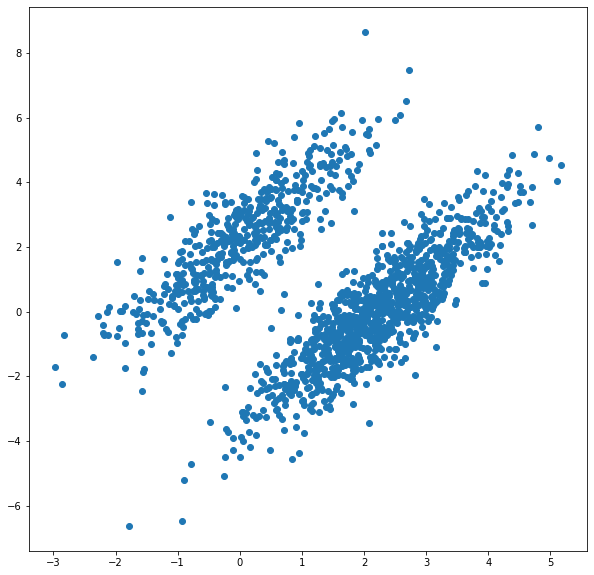

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(*X.T)

plt.show()

# `PART` I : EM Clustering

# `main` starts from here for EM Clustering

# 1. Prediction

In [17]:
em = EXP_MAX(X, 2, 20)
time.sleep(2)

In [18]:
em.predict()

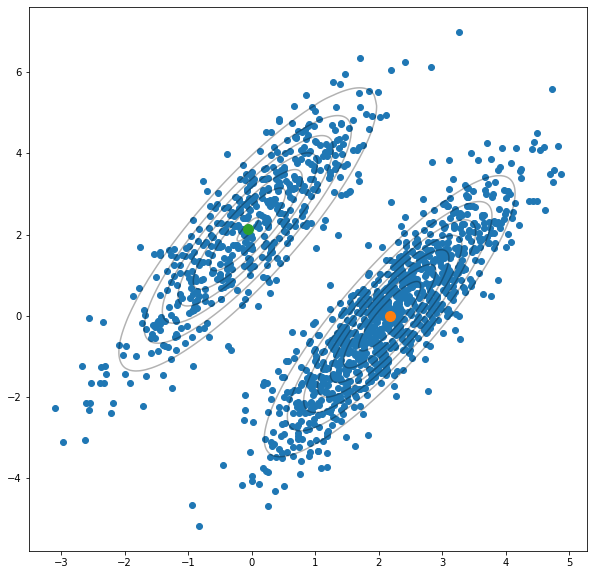

In [19]:
em.plot()

In [20]:
predicted_mu1 = np.around(em.mu[1], 1)
predicted_mu2 = np.around(em.mu[0], 1)

In [21]:
predicted_cov1 = np.around(em.cov[1], 1)
predicted_cov2 = np.around(em.cov[0], 1)

# `PART` II : k-Means

# `main` starts from here for K-Means Clustering

In [36]:
k = 2
km2 = KMeans(k, X, show_plot=False)

In [37]:
predicted_label_km = km2.predict()

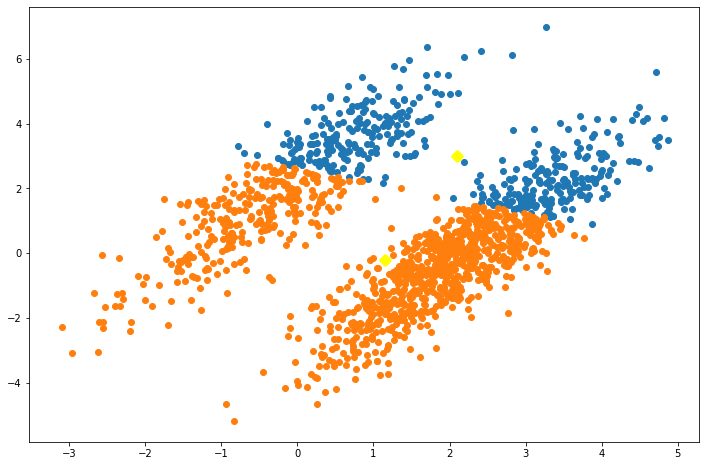

In [38]:
km2.plot()

# `PART` III : Accuracy

## 1. Accuracy of K-Means

In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [40]:
confusion_matrix(Y, predicted_label_km)

array([[214, 786],
       [212, 288]])

In [42]:
1 - accuracy_score(Y, predicted_label_km)

0.6653333333333333

In [43]:
accuracy_score(Y, predicted_label_km)

0.33466666666666667

## 2. Accuracy of Expectation Maximization (EM)

### Ground Truth `Mean and Covarance`

In [28]:
mu1

array([2.2, 0. ])

In [29]:
mu2

array([0. , 2.2])

In [30]:
cov1

array([[1. , 1.5],
       [1.5, 3. ]])

In [31]:
cov2

array([[1. , 1.5],
       [1.5, 3. ]])

### Predicted `Mean and Covarance`

In [32]:
predicted_mu1

array([-0.1,  2.1])

In [33]:
predicted_mu2

array([ 2.2, -0. ])

In [34]:
predicted_cov1

array([[1. , 1.6],
       [1.6, 3.1]])

In [35]:
predicted_cov2

array([[0.9, 1.4],
       [1.4, 2.9]])